# Mendelian randomization analysis of ability to smell and Parkinson's disease

**Project:** Bidirectional relationship between anosmia and Parkinson's disease

**Version:** R/4.1

**Status:** COMPLETE

**Last Updated:** JUNE-2024

## Notebook Overview

This notebook will show the code used to run the direction from PD to ability to smell. The same pipeline was used to run the reverse direction.

In [1]:
libraries <- c("data.table", "tidyverse", "vroom", "dplyr", 'TwoSampleMR', 'ieugwasr', "MRPRESSO")
lapply(libraries, require, character.only = TRUE)

Loading required package: data.table

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purr

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

In [2]:
# some useful functions
"%+%" = function(...) paste0(...,sep="")
`%ni%` <- Negate(`%in%`)

# Mendelian Randomization (MR) Pipeline

MR using `TwoSampleMR` + `MRPRESSO` package is done in these steps:

1. Prepare exposure
2. Prepare outcome
3. Harmonize data
4. Check instrument/exposure validity
5. Run MR
6. Plot
7. Identify heterogeneity outliers using MR-PRESSO
8. Repeat 5-6 without the outliers

# 1. Prepare exposure

In [3]:
test_traits <- c("PD_clinical")
test_traits_ncase <- c(15056)
test_traits_ncontrol <- c(12637)
test_traits_prevalence <- c(0.005)
exposure_list <- list()

In [ ]:
trait <- 'PD_clinical'
ncase <- 15056
ncontrol <- 12637
samplesize <- ncase + ncontrol

trait_vroom <- vroom("data/formatted_sumstats/"%+% trait %+%"_formatted.tsv.gz", show_col_types = FALSE)

trait_vroom <- trait_vroom %>% filter(P<5e-8) %>% as.data.table

exposure_temp_formatted <- format_data(
    trait_vroom,
    type = "exposure",
    snp_col="SNP",
    chr_col="CHR",
    pos_col="BP",
    eaf_col = "MAF",
    effect_allele_col="A1",
    other_allele_col="A2",
    beta_col="BETA",
    se_col = "SE",
    pval_col = "P"
) %>% as.data.table

exposures <- exposure_temp_formatted[, c(
    "exposure",
    "ncase.exposure",
    "ncontrol.exposure",
    "samplesize.exposure"
) := list(
    trait,
    ncase,
    ncontrol,
    samplesize
)]

# 2. Prepare outcome data

Now we can just read the data as a data frame using `read_csv` and use the `format_data` function to convert to outcome data. But this takes forever and harmonization also takes forever.

We will subset the variants ahead of time so that only variants found in both the exposures and the outcome will be in the outcome data.

In [ ]:
trait <- "ability_to_smell"
samplesize <- 1427780

trait_vroom <- vroom("data/formatted_sumstats/"%+% trait %+%"_formatted.tsv.gz", show_col_types = FALSE)
trait_vroom <- trait_vroom %>% filter(SNP %in% exposures$SNP)
outcome_formatted <- format_data(
    trait_vroom,
    type = "outcome",
    snp_col="SNP",
    chr_col="CHR",
    pos_col="BP",
    eaf_col = "MAF",
    effect_allele_col="A1",
    other_allele_col="A2",
    beta_col="BETA",
    se_col = "SE",
    pval_col = "P"
) %>% as.data.table

outcome_formatted <- outcome_formatted[, c(
    "outcome",
    "samplesize.outcome"
) := list(
    trait,
    samplesize
)]

# 3. Harmonize data

Note that when you harmonize data, `TwoSampleMR` tries to be a little conservative and drop SNPs that are potential palindromics since it is unsure if the variants are both in + strands. For this I am leaving this behavior as is, but if you are 100% sure all data is in forward strand, you can use `action = 1` argument to skip this process.

In [ ]:
PD_ability_to_smell_harmonized <- harmonise_data(
    exposures,
    outcome_formatted
) %>% as.data.table

Now we will clump the data. Following is a function to clump data using local 1000 Genome data, rather than using the IEU OpenGWAS API, which can stall with large number of variants. This is absolutely critical the for direction from ability to smell -> PD, as the olfaction is a very polygenic trait with hundreds of independent variants.

In [ ]:
clump_per_combination <- function(DT, local=T, plink='refdata/plinkv1_9/plink', bfile='refdata/1kg_plink/EUR', clump_kb = 10000, clump_r2 = 0.001, mr_keep=T) {
    exposures <- DT$exposure %>% unique
    if ('outcome' %in% colnames(DT)) {
        outcomes <- DT$outcome %>% unique
        combinations <- expand.grid(exposures, outcomes) %>% as.data.table
    } else {
        # no outcomes, only exposures
        combinations <- data.table(Var1 = exposures, Var2 = NA)
    }
    

    return_list <- list()
    for (i in 1:nrow(combinations)) {
        exposure_interest <- combinations[i]$Var1
        outcome_interest <- combinations[i]$Var2
        if (is.na(outcome_interest)) {
            # only exposures
            harmo <- DT[exposure == exposure_interest]
        } else {
            harmo <- DT[exposure == exposure_interest & outcome == outcome_interest]
        }
        if (mr_keep & ('mr_keep' %in% colnames(harmo))) {
            harmo <- harmo[mr_keep == T]
        }
        if (local==T) {
            clump_harmo <- ieugwasr::ld_clump(
                harmo %>% rename('rsid'='SNP','pval'='pval.exposure'),
                plink_bin = plink,
                clump_kb = clump_kb,
                clump_r2 = clump_r2,
                bfile = bfile
            )
            clump_harmo <- clump_harmo %>% rename('SNP'='rsid','pval.exposure'='pval')
        } else {
            clump_harmo <- clump_data(harmo, clump_kb = clump_kb, clump_r2 = clump_r2)
        }
        return_list[[i]] <- clump_harmo
    }
    return(rbindlist(return_list))
}

In [ ]:
backup <- PD_ability_to_smell_harmonized %>% copy()
PD_ability_to_smell_harmonized <- clump_per_combination(PD_ability_to_smell_harmonized)

Now note that just like how you can combine the different exposures, you can do this with multiple outcomes and concatenate/rbind the harmonized data frames together and run MR all together. The MR function runs MR on each exposure and outcomes separately.

# 4. Check F-statistic

When you run MR, you need to make sure that the instrumental variants (IVs) we are using are a good representative of the exposure. This can be determined by calculating the F-statistic (F_STAT) of each IVs. In mendelian randomization IVs are the SNPs we are using.

What we want to see are IVs with F_STAT >= 10. From here you can be stringent and remove any IVs with F_STAT < 10 or just check that the mean F_STAT is 10 or greater.

In [ ]:
PD_ability_to_smell_harmonized <- PD_ability_to_smell_harmonized %>% as.data.table

In [ ]:
PD_ability_to_smell_harmonized[, F_STAT := qf(
    pval.exposure,
    df1=1,
    df2=samplesize.exposure,
    lower.tail=F
)]
PD_ability_to_smell_harmonized[!is.na(F_STAT)]$F_STAT %>% min

In [ ]:
# backup just in case we need to rerun this
fwrite(PD_ability_to_smell_harmonized, 'data/PD_to_smell_harmonisedIV_backup.csv')
# PD_ability_to_smell_harmonized <- fread("PD_to_smell_harmonisedIV_backup.csv")

# 5. Run MR

Finally the fun part! We will run MR using 3 meta-analysis methods:

1. Inverse-variance weighted (IVW) - the classic random-effect meta-analysis. The most powerful of the bunch but is vulnerable to pleiotropic effects.
2. MR Egger - designed to detect and compensate for pleiotropic variants. It unconstrains the intercept which can dramatically change the coefficient. Pay close attention to the effect direction of MR Egger and IVW results. If they are in opposite directions, it means there is a strong evidence for pleiotropy.
3. Weighted Median (WM) - designed to compensate for potential invalid instruments. Only works when half or more instruments are valid. It is a good hedge in case some of the variants are less relevant than others.

We will also run Cochran's Q heterogeneity test and Egger test for pleiotropy. We will also calculate I^2 to quantify the heterogeneity.

In [ ]:
PD_ability_to_smell_harmonized <- fread("data/PD_to_smell_harmonisedIV_backup.csv")

In [ ]:
PD_ability_to_smell_harmonized <- PD_ability_to_smell_harmonized[exposure == 'PD_clinical']

Main MR

In [ ]:
resMR <- mr(
    PD_ability_to_smell_harmonized,
    method_list = c("mr_ivw","mr_egger_regression","mr_weighted_median")
) %>% as.data.table
resMR[,c("exposure","outcome","method","nsnp","b","se","pval","id.exposure","id.outcome")][order(exposure,outcome,method)]

Heterogeneity analysis

In [ ]:
hetMR <- mr_heterogeneity(
    PD_ability_to_smell_harmonized,
    method_list = c("mr_ivw","mr_egger_regression")
) %>% as.data.table
hetMR[, Isq := round((Q-Q_df)/Q*100, digits = 3)]
hetMR[,c("exposure","outcome","method","Q","Q_df","Q_pval","Isq","id.exposure","id.outcome")][order(exposure,outcome,method)]

Egger intercept pleiotropy analysis

In [ ]:
pleMR <- mr_pleiotropy_test(PD_ability_to_smell_harmonized) %>% as.data.table
pleMR[,c("exposure","outcome","egger_intercept","se","pval","id.exposure","id.outcome")][order(exposure,outcome)]

Single variant (Wald-ratio) analysis

In [ ]:
singleMR <- mr_singlesnp(PD_ability_to_smell_harmonized) %>% as.data.table
singleMR

Leave-one-out

In [ ]:
looMR <- mr_leaveoneout(PD_ability_to_smell_harmonized) %>% as.data.table
looMR

In [ ]:
fwrite(
    resMR,
    "results/PD_smell.MR.csv"
)
fwrite(
    hetMR,
    "results/PD_smell.het.csv"
)
fwrite(
    pleMR,
    "results/PD_smell.ple.csv"
)
fwrite(
    looMR,
    "results/PD_smell.loo.csv"
)
fwrite(
    singleMR,
    "results/PD_smell.single.csv"
)

# 6. Plot

Couple of good ways to graph our results.

## 6a. Scatterplot

This is especially useful for comparing the MR Egger results and IVW results. It can also be used to look at heterogeneous results. High heterogeneity doesn't necessarily mean pleiotropy, as heterogeneous results that are evenly distributed between the regression would also be shown as significant in the Cochran's Q results.

In [ ]:
resMR_forPlot <- resMR %>% copy
resMR_forPlot[, exposure := "Parkinson's Disease"]
resMR_forPlot[, outcome := 'self-reported "ability to smell"']

PD_ability_to_smell_harmonized_forPlot <- PD_ability_to_smell_harmonized %>% copy
PD_ability_to_smell_harmonized_forPlot[, exposure := "Parkinson's Disease"]
PD_ability_to_smell_harmonized_forPlot[, outcome := 'Self-reported "ability to smell"']

scatter_plots <- mr_scatter_plot(
    resMR_forPlot,
    PD_ability_to_smell_harmonized_forPlot
)

$ES83X3.R8nAAo


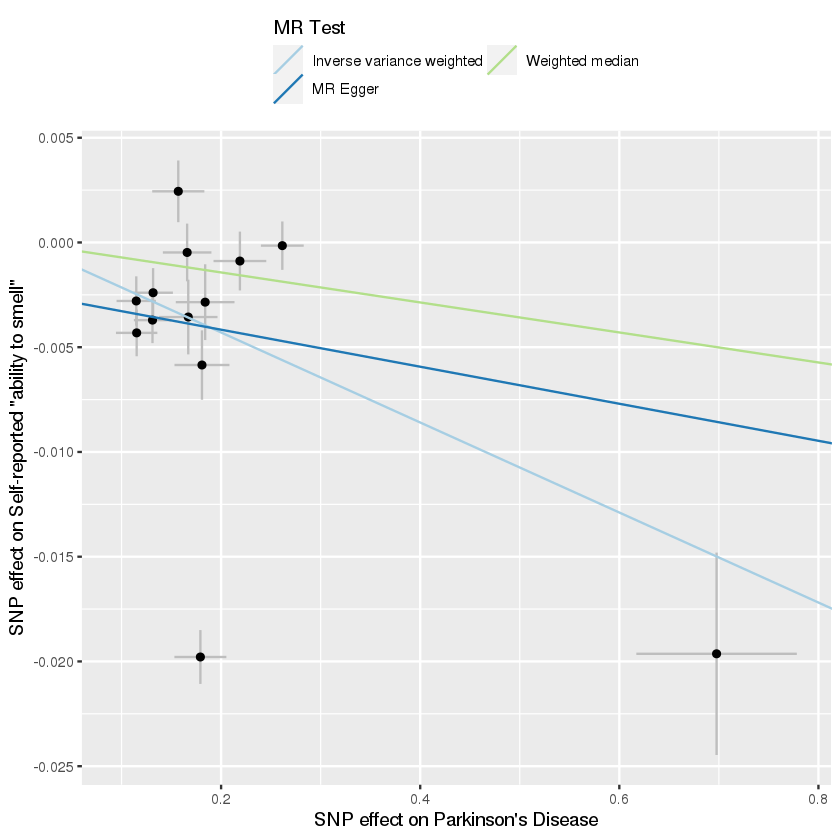

In [61]:
scatter_plots[1]

In [62]:
ggsave(
    "results/plots/PDonSmell.pdf",
    plot = scatter_plots[1]$ES83X3.R8nAAo
)


Saving 6.67 x 6.67 in image



## 6b. Forest plot

This plot is more useful to see individual SNP effects vs the meta-analysis results. It can help identify outliers.

When there are lots of IVs, it can be overwhelming. Let's do factor 2 since it has the leave number of IVs.

Warning message:
"Removed 1 rows containing missing values (geom_errorbarh)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


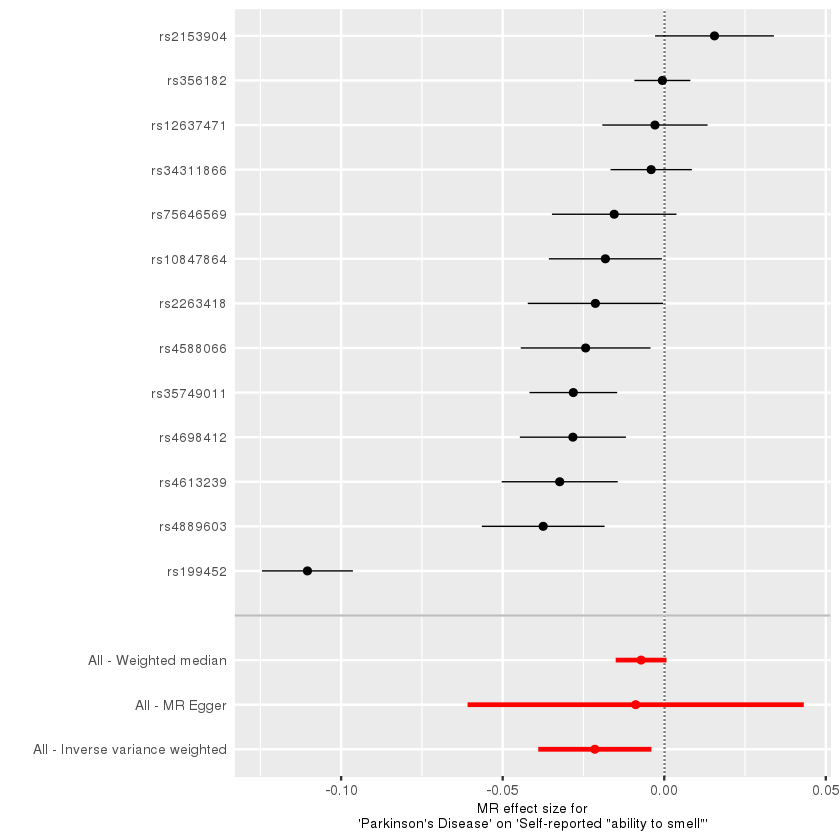

In [150]:
singleMR_forPlot <- mr_singlesnp(PD_ability_to_smell_harmonized_forPlot)
PD_ability_to_smell_forestplot <- mr_forest_plot(
    singleMR_forPlot,
)
PD_ability_to_smell_forestplot[[1]]

In [ ]:
ggsave(
    "results/plots/PDonSmell.ForestPlot.pdf",
    plot = PD_ability_to_smell_forestplot[[1]]
)

## 6c. Leave one out plot

In [ ]:
looMR_forPlot <- mr_leaveoneout(PD_ability_to_smell_harmonized_forPlot) %>% as.data.table
LOO_plot <- mr_leaveoneout_plot(looMR_forPlot)
ggsave(
    "results/plots/PDonSmell.LOO_ForestPlot.pdf",
    plot = LOO_plot[[1]]
)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


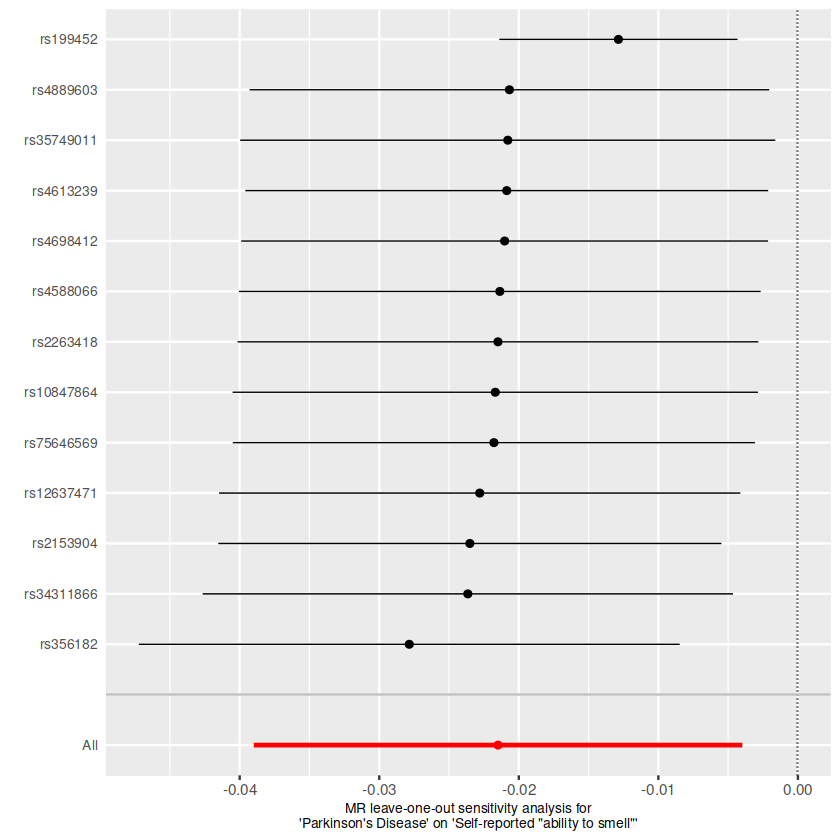

In [33]:
LOO_plot[[1]]

# 7. MR-PRESSO

When an exposure has high heterogeneity between its IVs, we can use MR-PRESSO to identify potential outliers that may be skewing our results. Let's run this for Factor 4.

This test can take a long time depending on the number of IVs. Small ones like Factor 3 will probably finish by the time you get your coffee. Factor 4 will likely take hour(s). This is because MR-PRESSO doesn't support multi-threading at the moment. Feel free to let it run and come back to it later.

Make sure you convert any `data.table` object to `data.frame` since MR-PRESSO is finicky and will not accept `data.table` objects.

You need to set the `NbDistribution` high enough so that the tests do not fail. Higher the number longer the test takes, but you need higher number for higher number of IVs. An easy way to do this is:

In [ ]:
trait <- 'PD_clinical'
data <- PD_ability_to_smell_harmonized[exposure == trait] %>% as.data.frame
NbDistNum <- nrow(data)/0.05 + 100

PRESSO_RESULT <- mr_presso(
    BetaOutcome = "beta.outcome",
    BetaExposure = "beta.exposure",
    SdOutcome = "se.outcome",
    SdExposure = "se.exposure",
    OUTLIERtest = TRUE,
    DISTORTIONtest = TRUE,
    data = data,
    NbDistribution = NbDistNum,
    SignifThreshold = 0.05
)
saveRDS(PRESSO_RESULT, "results/PD_smell_MRPRESSO.rds")

Now go do something else. Come back later.

# 8. Repeat MR without outliers

In [ ]:
PRESSO_RESULT <- readRDS("results/PD_smell_MRPRESSO.rds")
# check to make sure the actual MR-PRESSO found outliers
PRESSO_RESULT

In [ ]:
outliers <- PRESSO_RESULT$`MR-PRESSO results`$`Distortion Test`$`Outliers Indices`
postPRESSO_harmonized <- PD_ability_to_smell_harmonized[!outliers]

## What are the "outliers"?

In [ ]:
outliers <- PD_ability_to_smell_harmonized[
    SNP %ni% postPRESSO_harmonized$SNP
][,c("SNP","chr.exposure", "pos.exposure", "beta.exposure", "se.exposure", "pval.exposure", "beta.outcome", "se.outcome", "pval.outcome")][order(chr.exposure,pos.exposure)]

In [ ]:
nonOutliers <- postPRESSO_harmonized[,c("SNP","chr.exposure", "pos.exposure", "beta.exposure", "se.exposure", "pval.exposure", "beta.outcome", "se.outcome", "pval.outcome")][order(chr.exposure,pos.exposure)]

In [ ]:
outliers <- outliers[, `Removed by MR-PRESSO Distortion Test` := T]
nonOutliers <- nonOutliers[, `Removed by MR-PRESSO Distortion Test` := F]

In [148]:
All_IVs <- rbind(outliers, nonOutliers)
All_IVs

SNP,chr.exposure,pos.exposure,beta.exposure,se.exposure,pval.exposure,beta.outcome,se.outcome,pval.outcome,Removed by MR-PRESSO Distortion Test
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
rs2153904,1,205642790,0.1570,0.0262,1.989e-09,0.002441910,0.00147316,9.73962e-02,TRUE
rs34311866,4,951947,0.2189,0.0265,1.538e-16,-0.000886335,0.00140517,5.28192e-01,TRUE
rs356182,4,90626111,0.2615,0.0215,4.933e-34,-0.000151649,0.00115533,8.95569e-01,TRUE
rs199452,17,44801340,-0.1792,0.0261,6.460e-12,0.019787700,0.00128609,2.05377e-53,TRUE
rs35749011,1,155135036,0.6977,0.0806,4.713e-18,-0.019635100,0.00483205,4.83400e-05,FALSE
rs4613239,2,169119609,0.1808,0.0276,5.964e-11,-0.005849510,0.00165651,4.13648e-04,FALSE
rs12637471,3,182762437,-0.1659,0.0244,9.784e-12,0.000476829,0.00137900,7.29509e-01,FALSE
rs4698412,4,15737348,-0.1311,0.0187,2.209e-12,0.003706840,0.00109754,7.31707e-04,FALSE
rs75646569,5,60345424,0.1840,0.0295,4.386e-10,-0.002849300,0.00180901,1.15241e-01,FALSE


Outliers: NUCKS1, TMEM175, SNCA, MAPT

Kept: GBA, STK39, MCCC1, BST1, ELOVL7, LRRK2, HIP1R, SETD1A, RIT2

In [ ]:
All_IVs <- All_IVs %>% rename(
    "CHR"="chr.exposure",
    "BP"="pos.exposure"
)

In [ ]:
singleMR_for_merge <- singleMR[exposure=="PD_clinical"][,c("exposure","outcome","SNP","b","se","p")] %>% rename(
    "Effect (Wald Ratio)"="b",
    "SE (Wald Ratio)"="se",
    "P (Wald Ratio)"="p"
)

In [ ]:
All_IVs_Single <- merge(All_IVs, singleMR_for_merge)

In [152]:
nrow(All_IVs_Single)

[1] 13

In [ ]:
fwrite(
    All_IVs_Single[order(CHR,BP)],
    "results/PD_IVs.csv"
)

Main MR

In [ ]:
resMR <- mr(
    postPRESSO_harmonized,
    method_list = c("mr_ivw","mr_egger_regression","mr_weighted_median")
) %>% as.data.table
resMR[,c("exposure","outcome","method","nsnp","b","se","pval","id.exposure","id.outcome")][order(exposure,outcome,method)]

Heterogeneity analysis

In [ ]:
hetMR <- mr_heterogeneity(
    postPRESSO_harmonized,
    method_list = c("mr_ivw","mr_egger_regression")
) %>% as.data.table
hetMR[, Isq := round((Q-Q_df)/Q*100, digits = 3)]
hetMR[,c("exposure","outcome","method","Q","Q_df","Q_pval","Isq","id.exposure","id.outcome")][order(exposure,outcome,method)]

Egger intercept pleiotropy analysis

In [ ]:
pleMR <- mr_pleiotropy_test(postPRESSO_harmonized) %>% as.data.table
pleMR[,c("exposure","outcome","egger_intercept","se","pval","id.exposure","id.outcome")][order(exposure,outcome)]

Single variant (Wald-ratio) analysis

In [ ]:
singleMR <- mr_singlesnp(postPRESSO_harmonized) %>% as.data.table
singleMR

Leave-one-out

In [ ]:
looMR <- mr_leaveoneout(postPRESSO_harmonized) %>% as.data.table
looMR

In [ ]:
fwrite(
    resMR,
    "results/PD_smell-POSTPRESSO.MR.csv"
)
fwrite(
    hetMR,
    "results/PD_smell-POSTPRESSO.het.csv"
)
fwrite(
    pleMR,
    "results/PD_smell-POSTPRESSO.ple.csv"
)
fwrite(
    looMR,
    "results/PD_smell-POSTPRESSO.loo.csv"
)
fwrite(
    singleMR,
    "results/PD_smell-POSTPRESSO.single.csv"
)